## Thesis Draft 

This is a copy of thesis_draft1, dated afternoon May 7, 3:28pm.

### Preamble Code

In [1]:
%load_ext autoreload
%autoreload 2

import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["KHEIRON_REGISTRY_PATH"] = '/mas/projects/molecularmachines/experiments/generative/allanc3/'

import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import chex
import haiku as hk

from kheiron.pipeline.registry import Registry

import json
from typing import List, Dict, Tuple, Union
from collections import defaultdict
from itertools import combinations
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import math
import string 
import random
import pickle
from tqdm import tqdm
import time

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# # For dataset processing
# from hydra_zen import instantiate
# from torch.utils.data import DataLoader

from moleculib.assembly.dataset import ChromaDataset
from moleculib.graphics.py3Dmol import plot_py3dmol, plot_py3dmol_grid
from moleculib.protein.datum import ProteinDatum

## Import transforms
from moleculib.protein.transform import (
    ProteinCrop,
    TokenizeSequenceBoundaries,
    ProteinPad,
    MaybeMirror,
    BackboneOnly,
    DescribeChemistry
)

from moleculib.assembly.transform import (
    StackProteins,
    UnstackProteins,
    ApplyToProteins,
    FilterProteinChains,
    ComplexPad,
)

# Helpful 
def whatis(*object):
    """Function to print the type and shape of an object, or list of objects."""
    for idx, obj in enumerate(object):
        if type(obj) is dict:
            print(f"object {idx} is a dictionary with length {len(obj)}")
            continue
        try:
            print(f"object {idx} is of type {type(obj)} and shape {obj.shape}")
        except AttributeError:  # assume list-like object otherwise
            try:
                obj_as_array = np.array(obj)
                print(f"object {idx} is of type {type(obj)}, in array form has shape {obj_as_array.shape}, and dtype {obj_as_array.dtype}")
            except ValueError:  # inhomogenous shape error
                print(f"object {idx} is of type {type(obj)} and length {len(obj)} (but inhomogenous shape)")

In [2]:
FOLDER_PREAMBLE = "../scripts/"
FOLDER = FOLDER_PREAMBLE + "denim-energy-1008-embeddings"
FOLDER_SMALL_FILES = FOLDER_PREAMBLE + "test-save"
embeddings_file = "encoded_dataset.pkl"
sliced_proteins_file = "sliced_dataset.pkl"

# Open both and store
with open(f"{FOLDER}/{embeddings_file}", "rb") as f:
    encoded_dataset = pickle.load(f)
with open(f"{FOLDER}/{sliced_proteins_file}", "rb") as f:
    sliced_dataset = pickle.load(f)

# Load the small folder's files
with open(f"{FOLDER_SMALL_FILES}/{embeddings_file}", "rb") as f:
    encoded_dataset_small = pickle.load(f)
with open(f"{FOLDER_SMALL_FILES}/{sliced_proteins_file}", "rb") as f:
    sliced_dataset_small = pickle.load(f)

### Setup Data and DataFrame

We first load and process the representation vectors for each hierarchy level into a cohesive database. Then, we can calculate structural similarity scores between any pair of protein datums, as well as analyze their respective representation vectors. 

There are two main components to this analysis. 

<ol>
<li>
 Because we are comparing proteins we need a notion of relative analysis, either pairwise or in clusters. 
</li>
To organize clusters we can employ algorithms like kmeans, or a radius-based clustering method. 

Pairwise analysis involves ranking the pairs in terms of proximity to each other (vector-wise), and then comparing their similarity in the level above (vector_wise). The first goal is to create a large `dataset` conducive to this "minimax". 
 

</ol>

In [6]:
from collections import defaultdict

class Representations:
    def __init__(self,):
        """Database of representation objects
            Distinguishes across different hierarchy levels
        """
        
        # This is the primary key (i.e. should not be manually adjusted)
        self.ids: List[int] = []
        self.PDBids: List[str] = []
        self.levels: List[int] = []  # hierarchy level
        self.level_idxs: List[int] = []  # id within a hierarchy level
        self.scalars: List[np.ndarray] = []  # scalar representation
        self.datums: List[ProteinDatum] = []  # protein datum
    
        self._pk_counter: int = 0

    def add_representation(self, PDBid, level, 
                            level_idx, scalar_rep, datum):
        """Add a `row` to the database"""
        self.ids.append(self._new_pk())
        self.PDBids.append(PDBid)
        self.levels.append(level)
        self.level_idxs.append(level_idx)
        self.scalars.append(scalar_rep)
        self.datums.append(datum)

    def _new_pk(self):
        self._pk_counter += 1 # increment the primary key counter
        return self._pk_counter
        
    def __repr__(self):
        return f"Representations object with {len(self.ids)} representations"
    
    def __len__(self):
        assert len(self.ids) == len(self.PDBids) == len(self.levels) == len(self.level_idxs) == len(self.scalars) == len(self.datums)
        return len(self.ids)
    

def populate_representations(encoded_dataset: Dict[str, Dict[int, np.ndarray]], sliced_dataset):
    """Populate the representations object with the encoded dataset"""
    reps = Representations()
    mismatches = defaultdict(dict)
    for idcode in encoded_dataset:
        levels = encoded_dataset[idcode]
        for level in levels:
            # print(f'ID: {idcode}')
            embeddings = encoded_dataset[idcode][level]
            protein_data = sliced_dataset[idcode][level]
            # print(f'Embeddings shape: {embeddings.shape}')
            # print(f"Type of protein_data: {type(protein_data)}, length: {len(protein_data)}")
            n_embeddings, n_protein_datums = embeddings.shape[0], len(protein_data)

            if n_embeddings != n_protein_datums:
                difference = n_embeddings - n_protein_datums
                mismatches[idcode][level] = (n_embeddings, n_protein_datums)
                protein_data.extend([None] * difference)

            for level_idx in range(n_embeddings):
                scalar_representation = embeddings[level_idx]
                protein_datum = protein_data[level_idx]
                reps.add_representation(
                    PDBid=idcode,
                    level=level,
                    level_idx=level_idx,
                    scalar_rep=scalar_representation,
                    datum=protein_datum
                )

    # Make it a DataFrame
    df = pd.DataFrame(
        {
            'pk': reps.ids,
            'PDBid': reps.PDBids,
            'level': reps.levels,
            'level_idx': reps.level_idxs,
            'scalars': reps.scalars,
            'datum': reps.datums
        }
    )

    return reps, df, mismatches


def get_column(df, pk=None, pdb_id=None, level=None, level_idx=None, column=None):
    """Get a column in a DataFrame given certain conditions.
        If no column is specified, return a view of the indexed
        DataFrame.
    """

    # Build out the indexing condition manually
    condition = True
    if pk is not None:
        if not isinstance(pk, list):
            pk = [pk]
        condition = (condition & (df['pk'].isin(pk)))
    if pdb_id is not None:
        if not isinstance(pdb_id, list):
            pdb_id = [pdb_id]
        condition = (condition & (df['PDBid'].isin(pdb_id)))
    if level is not None:
        if not isinstance(level, list):
            level = [level]
        condition = (condition & (df['level'].isin(level)))
    if level_idx is not None:
        if not isinstance(level_idx, list):
            level_idx = [level_idx]
        condition = (condition & (df['level_idx'].isin(level_idx)))

    if column is None:
        return df[condition]
    return df.loc[condition, column].values

def get_scalars(df, pk=None, pdb_id=None, level=None, level_idx=None):
    """Return the scalars given a selection. If `level_idx` is None
        then return the whole column (all the representation vectors
        for a specific PDBid given a hierarchy level)
    """
    return get_column(df, pk, pdb_id, level, level_idx, 'scalars')


In [5]:
reps_small, df_small, mismatches = populate_representations(encoded_dataset_small, sliced_dataset_small)
df_small.head()

,pk,PDBid,level,level_idx,scalars,datum
0,1,1azzC,0,0,"[-0.549283, -0.58408445, -2.9819953, 0.220291,...",(((<moleculib.protein.datum.ProteinDatum objec...
1,2,1azzC,0,1,"[-0.31266084, -0.46920484, -3.1005237, 0.06433...",(((<moleculib.protein.datum.ProteinDatum objec...
2,3,1azzC,0,2,"[-0.3545375, -0.3631149, -3.1173418, 0.0160872...",(((<moleculib.protein.datum.ProteinDatum objec...
3,4,1azzC,0,3,"[-0.364579, -0.38565072, -3.1116114, -0.017827...",(((<moleculib.protein.datum.ProteinDatum objec...
4,5,1azzC,0,4,"[-0.32814252, -0.50195915, -3.1007764, 0.08879...",(((<moleculib.protein.datum.ProteinDatum objec...


The data is loaded, let's now create edge connections between adjacent hierarchy levels.

In [102]:
# Plot protein datums via the primary key in the DataFrame

class PlotProteinDatum:
    def __init__(self, df):
        self.df = df

    def __call__(self, pk: Union[int, List[int]]):
        """Plot the protein datum given a primary key"""
        datum = get_column(self.df, pk=pk, column='datum')
        # print(datum)
        protein_plot = plot_py3dmol_grid([datum])
        # protein_plot.show()
        return protein_plot

plot_protein_datum = PlotProteinDatum(df_small)
plot_protein_datum([1,2])



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Connect Edges Between Adjacent Hierarchy Levels

In [8]:

kernel_size, stride = 5, 2
def connect_edges(df, kernel_size, stride):

    n_misses = 0
    edges_top_down, edges_bottom_up = dict(), dict()
    grouped_by_pdb = df.groupby('PDBid')

    # For each PDB...
    for pdb_id, pdb_group in grouped_by_pdb:
        unique_levels = sorted(pdb_group['level'].unique())

        # For each hierarchy level in the autoencoder...
        for level in unique_levels:
            lower_level, upper_level = level, level + 1  
            lower_level_group = pdb_group[pdb_group['level'] == lower_level].sort_values(by='level_idx')
            upper_level_group = pdb_group[pdb_group['level'] == upper_level].sort_values(by='level_idx')
            num_lower_level = len(lower_level_group)
            for start in range(0, num_lower_level, stride):
                end = start + kernel_size
                lower_level_slice = lower_level_group.iloc[start:end]
                # upper_level_node_index = start // stride
                upper_level_node_index = start 
                if upper_level_node_index < len(upper_level_group):
                    upper_level_node = upper_level_group.iloc[upper_level_node_index]

                    # Key is pk of upper node, value is list of pks for all lower nodes
                    edges_top_down[upper_level_node['pk']] = list(lower_level_slice['pk'])

                    # Key is pk of lower node, value is pk of upper node
                    edges_bottom_up.update(dict.fromkeys(lower_level_slice['pk'], upper_level_node['pk']))
                else:
                    n_misses += 1

        # print(f"Processed PDBid: {pdb_id}")

    return edges_top_down, edges_bottom_up, n_misses

edges_top_down, edges_bottom_up, n_misses = connect_edges(df_small, kernel_size, stride)
print(f"Missed: {n_misses} edges")


Missed: 1524 edges


### Pairwise Minimax

The first order of business is to organize by radius on a lower level and on an upper level. A within-level organization, either via a clustering algorithm or pairwise radius, will give local information about the vectors within. 

A between-level organization tells of the downstream effects of some global organization of information.

In [53]:
from sklearn.neighbors import radius_neighbors_graph, sort_graph_by_row_values


class SimilarityGraph:
    def __init__(self, df: pd.DataFrame):
        """Class to build a similarity graph from DataFrame"""
        self.df = df

        # Get the df where datum is not None
        self.df = self.df[self.df['datum'].notna()]

    def _get_scalars(self, pk=None, pdb_id=None, level=None, level_idx=None):
        """Return the scalar representations given a selection"""
        # Shape here is (N,), but return shape (N, M)
        sub_df = get_column(self.df, pk, pdb_id, level, level_idx)
        scalar_representations = sub_df['scalars']
        return np.stack(scalar_representations), sub_df

    def get_radius_neighbors(self, 
                             pk=None, pdb_id=None, level=None, level_idx=None, 
                             radius=1.0, sorted=False):
        """Return the indices of the scalar representations that are within a certain radius
            of each other.
        """
        scalar_reps, sub_df = self._get_scalars(pk, pdb_id, level, level_idx)
        # print(f"Processing {len(scalar_reps)} scalar representations")
        print(f"Shape of scalar reps: {scalar_reps.shape}")
        graph = radius_neighbors_graph(scalar_reps, radius, mode='distance', metric='euclidean')
        if sorted:
            graph = sort_graph_by_row_values(graph)
        return graph, sub_df

    def radius_of_edge_nodes(self, edges_bottom_up: Dict, 
                             pk=None, pdb_id=None, level=None, level_idx=None, radius=1.0):
        """Return the indices of the scalar representations that are within a certain radius
            of each other.
        """
        sub_df = get_column(self.df, pk, pdb_id, level, level_idx)
        print(f"Shape of input df: {self.df.shape}")
        print(f"Shape of sub df: {sub_df.shape}")

        # Use the pk in the sub df to get the corresponding value from `edges` dict
        nodes_i = []
        nodes_j = []
        for pk in sub_df['pk']:
            if pk not in edges_bottom_up:
                continue
            nodes_i.append(pk)
            nodes_j.append(edges_bottom_up[pk])
        assert len(nodes_i) == len(nodes_j)
        scalar_reps_i, sub_df_i = self._get_scalars(pk=nodes_i)
        graph_i = radius_neighbors_graph(scalar_reps_i, radius, mode='distance', metric='euclidean')
        scalar_reps_j, sub_df_j = self._get_scalars(pk=nodes_j)
        graph_j = radius_neighbors_graph(scalar_reps_j, radius, mode='distance', metric='euclidean')
        print(f"Shape of scalar reps i: {scalar_reps_i.shape}, shape of scalar reps j: {scalar_reps_j.shape}")
        return (graph_i, sub_df_i), (graph_j, sub_df_j)

sgraph = SimilarityGraph(df_small)

lvl3_graph, lvl3_df = sgraph.get_radius_neighbors(level=3, radius=1.0)

(graph_i, sub_df_i), (graph_j, sub_df_j) = sgraph.radius_of_edge_nodes(
    edges_bottom_up, level=[3,4], radius=1.0
)
whatis(lvl3_graph, lvl3_df)
# whatis(graph_i, sub_df_i, graph_j, sub_df_j)


Shape of scalar reps: (384, 64)
Shape of input df: (5889, 6)
Shape of sub df: (570, 6)
Shape of scalar reps i: (279, 64), shape of scalar reps j: (102, 89)
object 0 is of type <class 'scipy.sparse._csr.csr_matrix'> and shape (384, 384)
object 1 is of type <class 'pandas.core.frame.DataFrame'> and shape (384, 6)


In [99]:
from scipy.spatial.distance import euclidean


graph = lvl3_graph

arr1 = graph.toarray()
whatis(arr1)
rows, cols = arr1.nonzero()
print(f"Number of nonzero pairs: {rows.__len__()}, {cols.__len__()}")

# Every row, col pair is two representation vectors which are 
# within a certain radius of each other
# For each pair, we can find the corresponding superstructure
# at the next hierarchy level, and compare those vectors.
u1_pks, u2_pks, v1_pks, v2_pks, bottom_dists, top_dists = [], [], [], [], [], []
for row, col in zip(rows, cols):

    # Use the sub_df to match with location in the graph (index-based)
    u1, u2 = lvl3_df.iloc[row], lvl3_df.iloc[col]
    u1_pk, u2_pk = u1['pk'], u2['pk']
    if u1_pk not in edges_bottom_up or u2_pk not in edges_bottom_up:
        continue
    v1_pk, v2_pk = edges_bottom_up[u1_pk], edges_bottom_up[u2_pk]
    v1, v2 = df_small[df_small['pk'] == v1_pk], df_small[df_small['pk'] == v2_pk]
    # whatis(v1, v2)
    # print(f"Comparing {u1_pk} with {u2_pk}, and {v1_pk} with {v2_pk}")

    # Do Euclidean distance on the datums in v1, v2
    # euclidean(u1['scalars'], u2['scalars'])
    bottom_dist = np.linalg.norm(u1['scalars'] - u2['scalars'])

    scalars1, scalars2 = v1['scalars'], v2['scalars']
    if scalars1.shape != scalars2.shape:
        print(f"Shape mismatch: {scalars1.shape}, {scalars2.shape}")
        print(f"PKs: {v1_pk}, {v2_pk}")
        print(f"Level: {v1['level']}, {v2['level']}")
        print(f"Row, col: {row}, {col}")
    # print(scalars1, scalars2)
    top_dist = np.linalg.norm(v1['scalars'].values[0] - v2['scalars'].values[0])

    # `bottom_dst` should match the value in the graph at row, col
    # Verify the above claim
    assert math.isclose(bottom_dist, arr1[row, col], rel_tol=1e-5)

    u1_pks.append(u1_pk)
    u2_pks.append(u2_pk)
    v1_pks.append(v1_pk)
    v2_pks.append(v2_pk)
    bottom_dists.append(bottom_dist)
    top_dists.append(top_dist)


# Make a new DataFrame with these lists
df_compare = pd.DataFrame(
    {
        'u1_pk': u1_pks,
        'u2_pk': u2_pks,
        'v1_pk': v1_pks,
        'v2_pk': v2_pks,
        'bottom_dist': bottom_dists,
        'top_dist': top_dists
    }
)
df_compare.head()

object 0 is of type <class 'numpy.ndarray'> and shape (384, 384)
Number of nonzero pairs: 63840, 63840


,u1_pk,u2_pk,v1_pk,v2_pk,bottom_dist,top_dist
0,245,522,264,542,0.229385,0.037760
1,245,954,264,983,0.843521,0.252146
2,245,1397,264,1426,0.862510,0.252531
3,246,247,264,266,0.455713,0.857940
4,246,248,264,266,0.378089,0.857940


In [124]:
df_compare[['bottom_dist', 'top_dist']].describe()

# Get two columns from the DataFrame and describe them
def describe_columns(df, col1, col2):
    """Describe two columns in a DataFrame"""
    return df[[col1, col2]].describe()

describe_columns(df_compare, 'bottom_dist', 'top_dist')


,bottom_dist,top_dist
count,37708.000000,37708.000000
mean,0.628428,1.353739
std,0.205619,1.114581
min,0.015528,0.000000
25%,0.474113,0.348568
50%,0.621479,0.961710
75%,0.788930,2.466116
max,0.999988,4.764164


As we can see from preliminary inspection, lower hierarchies 

Number of points below 0.5 in bottom_dist and above 0.5 in top_dist: 7012


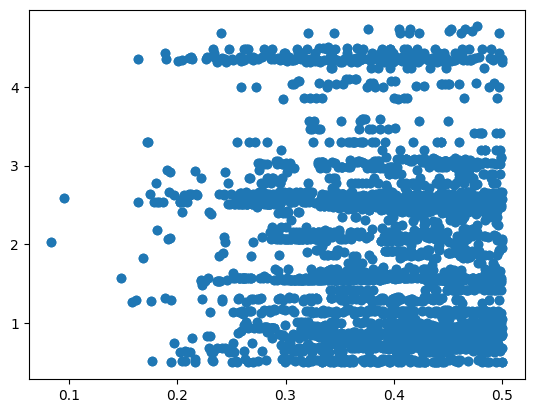

In [127]:
# Plot bottom distance against top distance

# Only plot those points which are below a certain threshold in the bottom_dist
# and above another threshold for the top_dist
threshold_bottom, threshold_top = 0.5, 0.5
df_filtered = df_compare[(df_compare['bottom_dist'] < threshold_bottom) & (df_compare['top_dist'] > threshold_top)]
print(f"Number of points below {threshold_bottom} in bottom_dist and above {threshold_top} in top_dist: {df_filtered.shape[0]}")
plt.scatter(df_filtered['bottom_dist'], df_filtered['top_dist']) 
plt.xlabel('Bottom distance')
plt.ylabel('Top distance')

In [100]:
df_compare['top_dist']

0        0.037760
1        0.252146
2        0.252531
3        0.857940
4        0.857940
           ...   
37703    2.415163
37704    2.405915
37705    2.415163
37706    2.405915
37707    4.151054
Name: top_dist, Length: 37708, dtype: float32

In [74]:
plot_protein_datum([df_compare['u1_pk'].iloc[0], df_compare['u2_pk'].iloc[0]]).show()
plot_protein_datum([df_compare['v1_pk'].iloc[0], df_compare['v2_pk'].iloc[0]])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Cluster and Variability

Cluster a lower level and calculate the variability measure as provided for by the adjacent hierarchy

In [121]:

from thesis.scripts.vector_utils import calculate_variability, compute_kmeans
from sklearn.cluster import KMeans

def cluster_variability(df, edges, lower_level, upper_level, N_CLUSTERS):
    """Takes in a populated representations DataFrame and dictionary
        of edges
    """
    cluster_degen = dict()
    # This returns the vectors (scalars) at the center of each cluster,
    # and a label for each scalar, regarding which cluster it belongs to
    centroids, labels = compute_kmeans(df, lower_level, n_clusters=N_CLUSTERS)

    lower_df = df.loc[df['level'] == lower_level, :].copy()
    upper_df = df.loc[df['level'] == upper_level]
    # display(lower_df.head())
    # print(len(labels), lower_df.shape)
    lower_df.loc[:, 'cluster'] = labels

    # Iterate through each cluster
    cluster_labels = sorted(lower_df['cluster'].unique())
    for cluster_label in cluster_labels:
        cluster_df = lower_df[lower_df['cluster'] == cluster_label]

        upper_nodes = cluster_df['pk'].map(edges)  # should be a list of top node ids
        upper_df_indexed = upper_df[upper_df['pk'].isin(upper_nodes)]

        # Check for empty df:
        if upper_df_indexed.empty:
            continue
        variability_for_upper_representations = calculate_variability(upper_df_indexed)  # returns tuple
        cluster_degen[cluster_label] = variability_for_upper_representations


    return cluster_degen, lower_df, labels


In [139]:
from sklearn.cluster import DBSCAN, KMeans

def cluster_variability_dynamic(df, edges, lower_level, upper_level, clustering_method, **kwargs):
    """Takes in a populated representations DataFrame and dictionary of edges, and allows dynamic clustering method selection."""
    cluster_degen = dict()
    
    lower_df = df.loc[df['level'] == lower_level, :].copy()
    upper_df = df.loc[df['level'] == upper_level]
    level_scalars = np.stack(get_scalars(df, level=lower_level))    
    if clustering_method == 'kmeans':
        kmeans = KMeans(n_clusters=kwargs.get('n_clusters', 5), n_init='auto')
        # level_scalars = np.array(list(df[df['level'] == lower_level]['scalars']))
        labels = kmeans.fit_predict(level_scalars)
    elif clustering_method == 'dbscan':
        dbscan = DBSCAN(eps=kwargs.get('eps', 0.5), min_samples=kwargs.get('min_samples', 5))
        labels = dbscan.fit_predict(level_scalars)
    else:
        raise ValueError("Unsupported clustering method provided. Use 'kmeans' or 'dbscan'.")
    
    lower_df.loc[:, 'cluster'] = labels

    # Iterate through each cluster
    cluster_labels = sorted(lower_df['cluster'].unique())
    for cluster_label in cluster_labels:
        cluster_df = lower_df[lower_df['cluster'] == cluster_label]

        upper_nodes = cluster_df['pk'].map(edges)  # should be a list of top node ids
        upper_df_indexed = upper_df[upper_df['pk'].isin(upper_nodes)]

        # Check for empty df:
        if upper_df_indexed.empty:
            continue
        variability_for_upper_representations = calculate_variability(upper_df_indexed)  # returns tuple
        cluster_degen[cluster_label] = variability_for_upper_representations

    return cluster_degen, lower_df, labels



In [145]:
all_levels = df_small['level'].unique()
print(f"All levels: {all_levels}")
lower_level, upper_level = all_levels[-3], all_levels[-2]
print(f"Lower level: {lower_level}, Upper level: {upper_level}")

# Do a DBSCAN now
degen, lower_df, labels = cluster_variability_dynamic(df_small, edges_bottom_up, lower_level, upper_level, 'dbscan', eps=0.5, min_samples=5)

# degen, lower_df, labels = cluster_variability_dynamic(df_small, edges_bottom_up, lower_level, upper_level, 'kmeans', n_clusters=7)

# degen, lower_df, labels = cluster_variability(df_small, edges_bottom_up, lower_level, upper_level, N_CLUSTERS=7)



All levels: [0 1 2 3 4]
Lower level: 2, Upper level: 3


In [146]:
cluster_results = {}
cluster_counts = [5, 7, 10, 11, 12, 13, 14, 15, 20]  # Different cluster counts to try

for count in cluster_counts:
    degen, _, _ = cluster_variability(df_small, edges_bottom_up, lower_level, upper_level, N_CLUSTERS=count)
    cluster_results[count] = degen

# Display the results for each cluster count
for count, results in cluster_results.items():
    print(f"Results for {count} clusters:")
    print(results)


Results for 5 clusters:
{0: (2.774330856697306, 2.774330853776928), 1: (2.2755030387311015, 2.27550303566701), 2: (2.8208841047663658, 2.8208841076083777), 3: (5.7219392761588095, 5.721939231455326), 4: (2.9539610272232952, 2.953961028427069)}
Results for 7 clusters:
{0: (2.7206452301402555, 2.7206452270630503), 1: (2.2755030387311015, 2.27550303566701), 2: (2.904556965455413, 2.904556968439227), 3: (1.8469494159022968, 1.8469493413964908), 4: (3.1780789426463967, 3.1780789408651406), 5: (5.919383387267589, 5.919383363425732), 6: (2.310713337136988, 2.3107133351534346)}
Results for 10 clusters:
{0: (2.7788033676661925, 2.778803364419406), 1: (2.2755030387311015, 2.27550303566701), 2: (2.9832016612565844, 2.983201664910025), 3: (1.8469494159022968, 1.8469493413964908), 4: (2.5012740074841426, 2.501274000261086), 5: (7.35022787962641, 7.350227915105366), 6: (2.267464485905517, 2.2674644863159306), 7: (3.396139704241751, 3.396139705285752), 9: (1.8469494159022968, 1.8469493413964908)}
Res

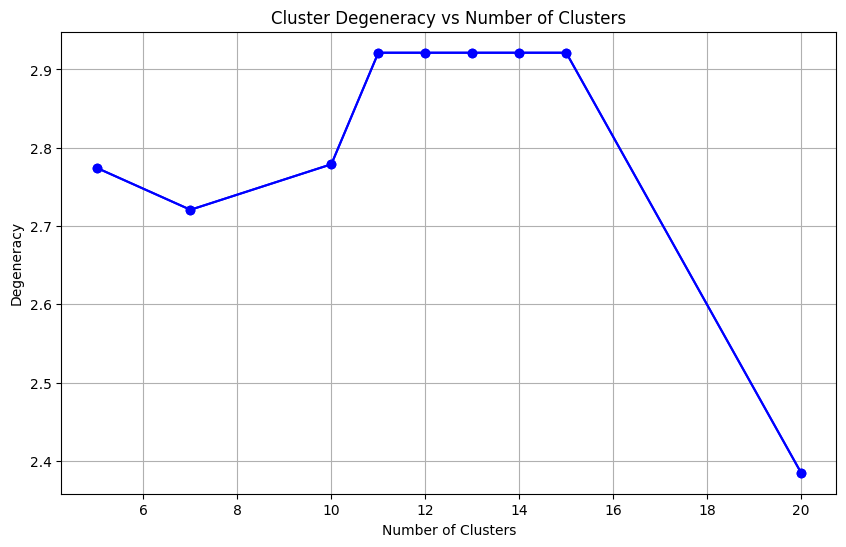

In [147]:
import matplotlib.pyplot as plt

# Prepare data for plotting
cluster_counts = list(cluster_results.keys())
degeneracies = [result[0] for result in cluster_results.values()]  # Assuming result[0] is the relevant metric

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, degeneracies, marker='o', linestyle='-', color='b')
plt.title('Cluster Degeneracy vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Degeneracy')
plt.grid(True)
plt.show()


Hypothesis: 

We wish to define the collection of smaller objects and we wish to show that this method is reasonably effective at finding them. 

Goal: Prove that these substructures are meaningful. How do we do this? 

Take a protein, take the substructures. Define a similarity metric on two proteins, whereby two proteins are similar if they have the same components. 

Protein A has components $a_1 \ldots a_n$, protein B has components $b_1 \ldots b_n$. If two proteins have the same components in the same order, they are fully similar. 

A protein is thus represented by a string of sub components. 

Suppose we have a string of sub-protein embeddings. Suppose we have a slightly longer one where we insert it in the middle. 


We pay for insertion or deletion, as well as l2 distance in sub protein embeddings space. 

Define some metric which is the infimum over all the ways of comparing the strings. 

It is unclear how to compute such a distance.


Define some distance, then define a greedy algorithm that computes some upper bound on this distance.



NB. Embeddings should be normalized if using cosine distance. 


Co-occurrence as a substructre of a certain protein is correlated


We are clustering our sub-proteins by which super guys we are sitting in. 
For each pair of sub-structures, (our sub-structures are not yet clustered), we can


There are certain kinds of sub-structures (let's say 6, for example). We have some number of sub-structures, each occurrence of a sub-structure can be modeled as some mean embedding value of the sub-structure + some hashing error. Model them as a Gaussian Mixture.



There are two essential methods o clustering: One by standard protein similarity metric, the other by these embedding vector metrics. 






1. Do a hierarchical Gaussian Mixture Model. Say we have 5 layers. Then we have that at each layer, we have some number $k1$ clusters for the first layer, all the way up to $k5$ layer for the last. Then, we want to embed into our model that we have this hierarchical dependence. What we say is this: Not only have we acquired these cluster means. We want to assert that we are fitting some hierarchical graph. For each node in our graph, we have a vector representing its mean, and it stores not just a mean (this vecor), but all the means of the subtructures itself. 

2. No no no, it should store not the means, but probability distributions over lower substructure indices. 